In [1]:
import math
import importlib
from typing import Literal

import torch
from torch import Tensor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ax import Client, RangeParameterConfig

from botorch.models import SingleTaskGP
from botorch.acquisition import qLogExpectedImprovement, qMaxValueEntropy

from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior

from src.model_generation import get_full_strategy
from src import GPVisualiser, ax_helper
from src.ax_helper import get_guess_coords


-0.0 -0.9874311636230129


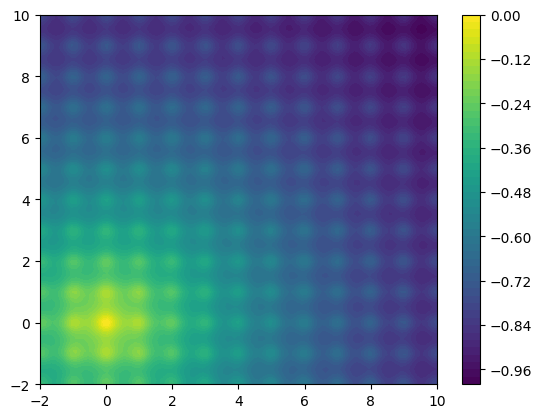

In [2]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    ),
    RangeParameterConfig(
        name="x2", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1", "x2"]


def test_function(x1, x2):
    # Ackley function (commonly used for optimization benchmarks)
    a = 20
    b = 0.2
    c = 2 * math.pi
    sum_sq = 0.5 * (x1**2 + x2**2)
    cos_comp = 0.5 * (math.cos(c * x1) + math.cos(c * x2))
    ackley_grid = -a * math.exp(-b * math.sqrt(sum_sq)) - math.exp(cos_comp) + a + math.exp(1)
    standardized = (ackley_grid-0.2434339681166695)/(19.3680592868830)
    return -standardized


import numpy as np
grid = np.linspace(-2, 10, 101)
x1_grid, x2_grid = np.meshgrid(grid, grid)
ackley_vals = np.array([test_function(x1, x2) for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel())]).reshape(x1_grid.shape)
ackley_vals
print(ackley_vals.max(), ackley_vals.min())


plt.contourf(x1_grid, x2_grid, ackley_vals, levels=60, cmap="viridis")
plt.colorbar()

# Sobol
The default initial parameter exploration strategy uses SOBOL algorithm:

### log param sobol:

[INFO 09-23 20:27:48] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-23 20:27:48] ax.api.client: Generated new trial 0 with parameters {'x0': 10.0, 'x1': 10.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-23 20:27:48] ax.api.client: Generated new trial 1 with parameters {'x0': 26.774104, 'x1': 25.813379} using GenerationNode Sobol.
[INFO 09-23 20:27:48] ax.api.client: Generated new trial 2 with parameters {'x0': 5.330513, 'x1': 3.93577} using GenerationNode Sobol.
[INFO 09-23 20:27:48] ax.api.client: Generated new tria

   trial_name         x0         x1
0         0_0  10.000000  10.000000
1         1_0  26.774104  25.813379
2         2_0   5.330513   3.935770
3         3_0   2.428654  59.642079
4         4_0  51.318277   1.650627
5         5_0  82.292437  43.462002
6         6_0   1.733262   2.098334
7         7_0   7.882820  11.214797
8         8_0  15.820373   9.778451
9         9_0  11.158007  97.553754
10       10_0   7.192774   1.114069
11       11_0   1.036316  21.069548
12       12_0  67.631113   4.367515
13       13_0  34.917802  16.406105
14       14_0   2.297091   5.946904
15       15_0   3.303669  39.572202
16       16_0  21.227598   2.590536
17       17_0  18.488189  35.891633
18       18_0   3.755841   3.138535
19       19_0   1.972820  13.569642
20       20_0  41.038206   6.540865
21       21_0  58.017396  18.455961
22       22_0   1.197579   5.098868
23       23_0   6.299960  83.364754
24       24_0  12.843344   1.274563
25       25_0  13.950168  12.665618
26       26_0   8.851626   8

<Axes: xlabel='x0', ylabel='x1'>

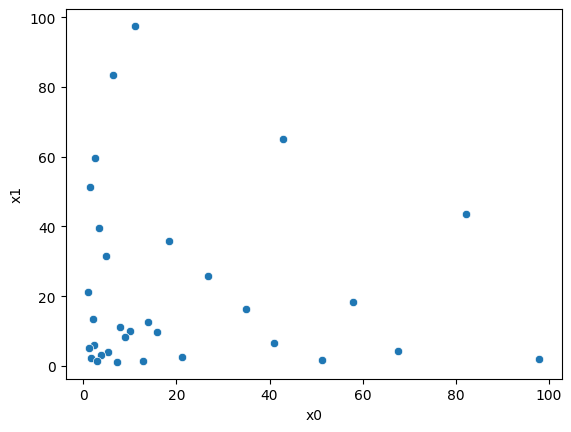

In [3]:
client = Client()

client.configure_experiment(
    name="batch_bo_test",
    parameters=[
        RangeParameterConfig(
            name=f"x{i}",
            bounds=(1, 100),
            parameter_type="float",
            scaling = 'log',
        ) for i in range(len(dim_names))
    ],
)


client.configure_optimization(objective="-loss")

client.get_next_trials(max_trials=32)

coords = get_guess_coords(client)
print(coords)
sns.scatterplot(data=coords, x="x0", y="x1")

Low value oversampling is inline with logarithmic distribution.

**Considering that we expect overexpression to be optimal when compared to underexpression, Sobol should be run on a linear scale**.

### linear parameters sobol

[INFO 09-23 20:27:48] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-23 20:27:49] ax.api.client: Generated new trial 0 with parameters {'x1': 50.5, 'x2': 50.5} using GenerationNode CenterOfSearchSpace.
[INFO 09-23 20:27:49] ax.api.client: Generated new trial 1 with parameters {'x1': 87.031061, 'x2': 11.084288} using GenerationNode Sobol.
[INFO 09-23 20:27:49] ax.api.client: Generated new trial 2 with parameters {'x1': 21.288832, 'x2': 59.913925} using GenerationNode Sobol.
[INFO 09-23 20:27:49] ax.api.client: Generated new t

<Axes: xlabel='x1', ylabel='x2'>

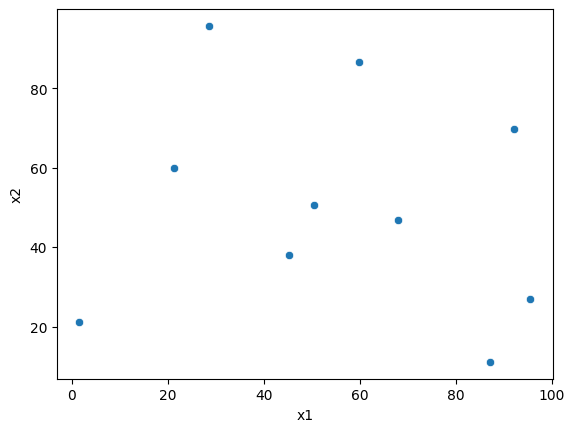

In [4]:
client = Client()

parameters=[
    RangeParameterConfig(
        name=dim,
        bounds=(1, 100),
        parameter_type="float",
        # scaling = 'log',
    ) for dim in dim_names
]


client.configure_experiment(
    name="batch_bo_test",
    parameters=parameters
)

client.configure_optimization(objective="response")
client.get_next_trials(max_trials=10)

coords = get_guess_coords(client)

sns.scatterplot(data=coords, x="x1", y="x2")

A nice and informative initial guess grid is formed

[INFO 09-23 20:27:49] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-23 20:27:49] ax.api.client: Generated new trial 0 with parameters {'x1': 4.0, 'x2': 4.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-23 20:27:49] ax.api.client: Generated new trial 1 with parameters {'x1': 7.740539, 'x2': 8.654849} using GenerationNode Sobol.
[INFO 09-23 20:27:49] ax.api.client: Generated new trial 2 with parameters {'x1': -1.235261, 'x2': 0.46577} using GenerationNode Sobol.
[INFO 09-23 20:27:49] ax.api.client: Generated new trial 3

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'GP along x1'}, xlabel='x1', ylabel='response'>,
        <Axes: title={'center': 'GP along x2'}, xlabel='x2', ylabel='response'>],
       dtype=object))

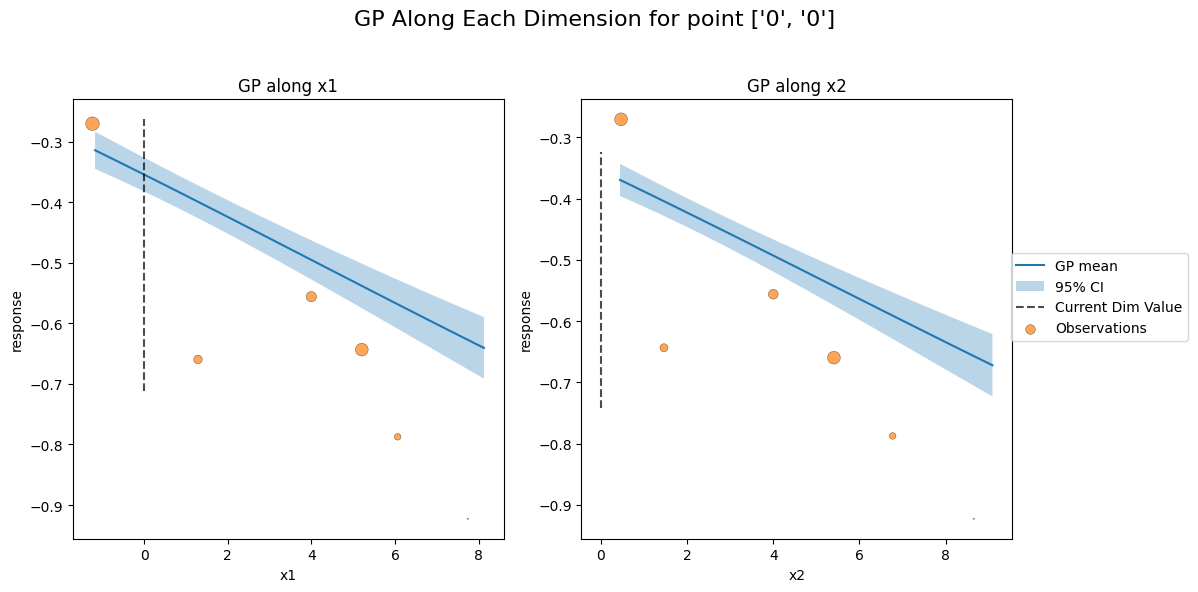

In [ ]:
client = Client()

client.configure_experiment(parameters=range_parameters)


client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=6, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

df = ax_helper.get_obs_from_client(client, response_col='response')
plotter = GPVisualiser.GPVisualiserMatplotlib(SingleTaskGP, df, dim_names, 'response', parameters)
plotter.plot_all([0,0])

In [ ]:
df

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-0.556069
1,1_0,7.740539,8.654849,-0.922690
2,2_0,-1.235261,0.465770,-0.270464
3,3_0,1.287259,5.407921,-0.659703
4,4_0,5.206479,1.462693,-0.643464
5,5_0,6.064018,6.771483,-0.787384


# Custom Botorch model

### Define the GP surrogate


MES (max value entropy search) should be the ideal choice for acquisition functions because:
* It can handle noise.
* Samples in a manner to best define the optimum.
    * Consequently, will rarely repeat exactly identical samplings.
* Has a cost/fidelity setting

In [7]:
client = Client()
generation_strategy = get_full_strategy(gp=SingleTaskGP, acqf_class=qLogExpectedImprovement)
client.configure_experiment(parameters=range_parameters)

client.set_generation_strategy(
    generation_strategy=generation_strategy,
)
client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=6, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

[INFO 09-23 20:27:49] ax.api.client: Generated new trial 0 with parameters {'x1': 4.0, 'x2': 4.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-23 20:27:49] ax.api.client: Generated new trial 1 with parameters {'x1': 5.500583, 'x2': -1.47111} using GenerationNode Sobol.
[INFO 09-23 20:27:49] ax.api.client: Generated new trial 2 with parameters {'x1': 3.390876, 'x2': 7.137266} using GenerationNode Sobol.
[INFO 09-23 20:27:49] ax.api.client: Generated new trial 3 with parameters {'x1': -0.640364, 'x2': 2.544409} using GenerationNode Sobol.
[INFO 09-23 20:27:49] ax.api.client: Generated new trial 4 with parameters {'x1': 7.65682, 'x2': 5.937872} using GenerationNode Sobol.
[INFO 09-23 20:27:49] ax.api.client: Generated new trial 5 with parameters {'x1': 9.67051, 'x2': 1.058201} using GenerationNode Sobol.
[INFO 09-23 20:27:49] ax.api.client: Trial 0 marked COMPLETED.
[INFO 09-23 20:27:49] ax.api.client: Trial 1 marked COMPLETED.
[INFO 09-23 20:27:49] ax.api.client: Trial 2 marked COM

[INFO 09-23 20:27:52] ax.api.client: Generated new trial 6 with parameters {'x1': 0.925183, 'x2': 1.806351} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-23 20:27:52] ax.api.client: Generated new trial 7 with parameters {'x1': -1.013625, 'x2': 3.747369} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-23 20:27:52] ax.api.client: Generated new trial 8 with parameters {'x1': -2.0, 'x2': -0.053122} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-23 20:27:52] ax.api.client: Generated new trial 9 with parameters {'x1': 0.690756, 'x2': 2.705447} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-23 20:27:52] ax.api.client: Generated new trial 10 with parameters {'x1': -2.0, 'x2': 4.035975} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-23 20:27:52] ax.api.client: Generated new trial 11 with parameters {'x1': 1.471636, 'x2': 1.33124} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[IN

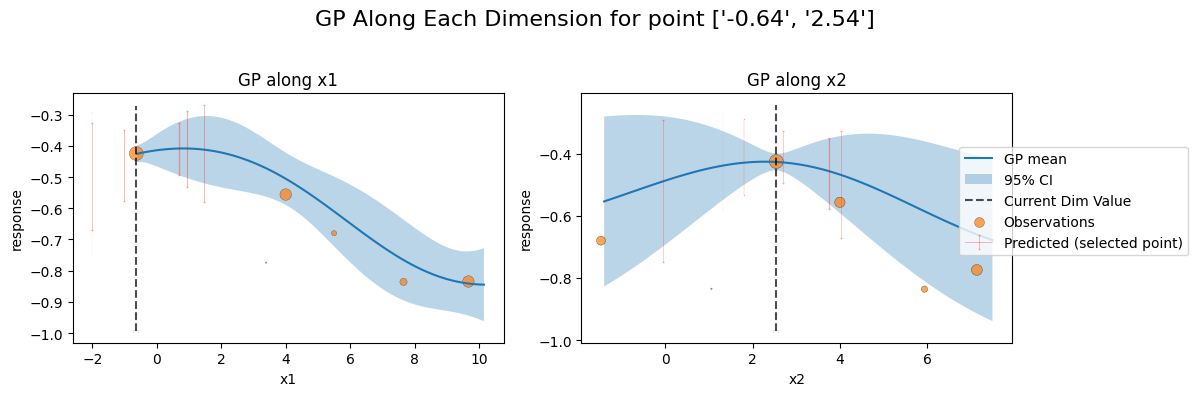

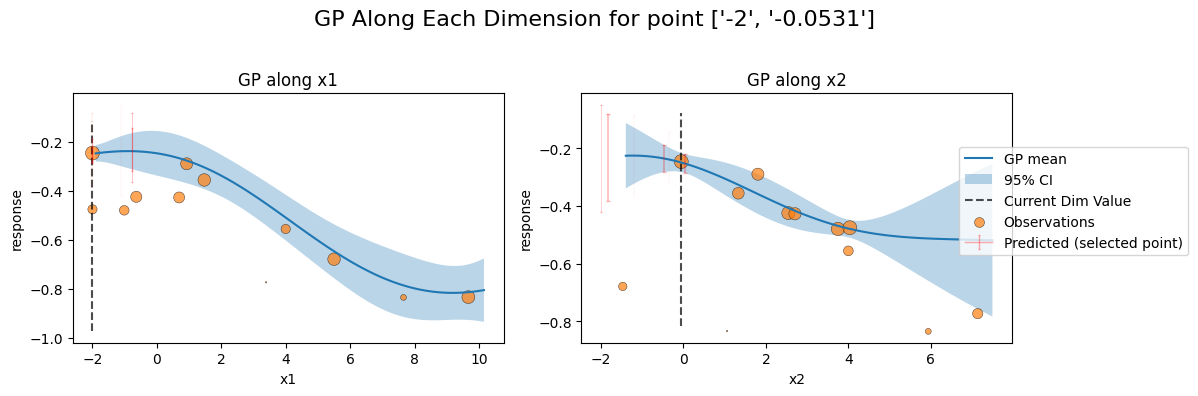

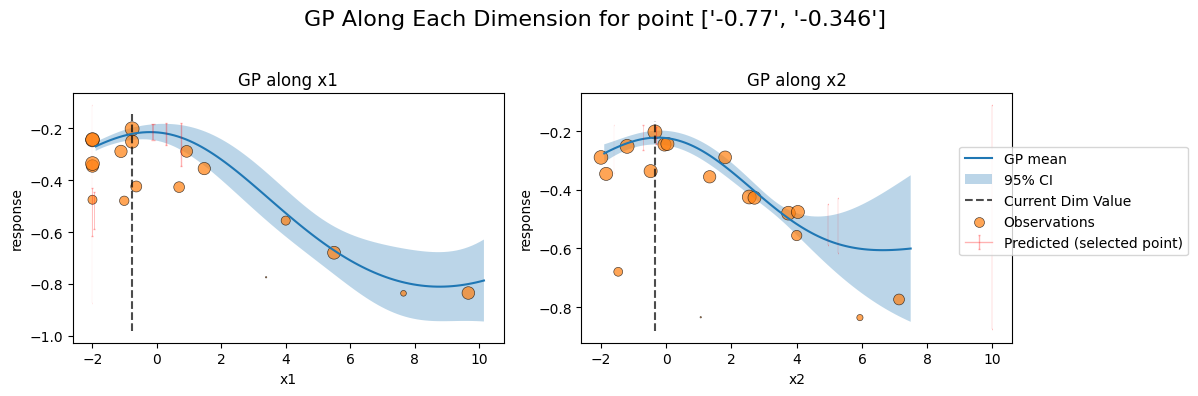

In [8]:
import matplotlib.pyplot as plt
for _ in range(3):
    batch_handler.get_next_batch()

    batch_handler.plot_GP(SingleTaskGP, figsize=(12, 4))
    batch_handler.complete_all_pending()

In [ ]:
df

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-0.556069
1,1_0,7.740539,8.654849,-0.922690
2,2_0,-1.235261,0.465770,-0.270464
3,3_0,1.287259,5.407921,-0.659703
4,4_0,5.206479,1.462693,-0.643464
5,5_0,6.064018,6.771483,-0.787384


# Technical repeats
Knowing that real biological data posses significant significant noise, the model has to be robust enough to handle technical repeats

In [10]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1"]

def test_function(x1):
    # Original: y = -((x1 - 2) ** 2) + 10  -> range on [-2,10] is [-54, 10]
    y = -((x1 - 2) ** 2) + 10
    return (y + 54) / 64  # scale to [0,1]


noise_fn = lambda x: x + np.random.normal(0, 1)

def plot_test():
    plt.plot(np.linspace(-2, 10, 100), [test_function(x) for x in np.linspace(-2, 10, 100)], color='black', label='True function')

In [ ]:
class SequentialRuns:
    """Simulate sequential Bayesian optimization with batches and technical repeats.

    Initialized with a test (objective) function so different objectives can reuse the logic.
    """

    def __init__(self, test_fn, range_parameters, dim_names, metric_name):
        self.test_fn = test_fn
        self.range_parameters = range_parameters
        self.dim_names = dim_names
        self.metric_name = metric_name

    def run(
        self,
        gp,
        acqf_class=qLogExpectedImprovement,
        n_runs=10,
        batch_size=1,
        technical_repeats=1,
        noise_fn=None,
        plot_each=False,
    ):
        client = Client()
        client.configure_experiment(parameters=self.range_parameters)
        client.configure_optimization(objective=self.metric_name)

        if noise_fn is None:
            def noise_fn(x): return x

        generation_strategy = get_full_strategy(gp=gp, acqf_class=acqf_class)
        client.set_generation_strategy(generation_strategy=generation_strategy)

        handler = ax_helper.BatchClientHandler(
            client,
            self.test_fn,
            self.dim_names,
            self.metric_name,
            batch_size=batch_size,
            range_params=self.range_parameters,
        )
        handler.get_next_batch(batch_size)

        for _ in range(n_runs):
            handler.comp_noise_and_repeats(noise_fn=noise_fn, repeats=technical_repeats)
            handler.get_next_batch()
            if plot_each:
                handler.plot_GP(gp, figsize=(8, 4))
                plot_test()
                plt.show()
        return handler
SequentialRuns

__main__.SequentialRuns

[INFO 09-23 20:28:01] ax.api.client: Generated new trial 0 with parameters {'x1': 4.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-23 20:28:01] ax.api.client: Generated new trial 1 with parameters {'x1': 5.128747} using GenerationNode Sobol.
[INFO 09-23 20:28:01] ax.api.client: Generated new trial 2 with parameters {'x1': 0.458649} using GenerationNode Sobol.
[INFO 09-23 20:28:01] ax.api.client: Trial 0 marked COMPLETED.
[INFO 09-23 20:28:01] ax.api.client: Trial 3 marked COMPLETED.
[INFO 09-23 20:28:01] ax.api.client: Trial 1 marked COMPLETED.
[INFO 09-23 20:28:01] ax.api.client: Trial 4 marked COMPLETED.
[INFO 09-23 20:28:01] ax.api.client: Trial 2 marked COMPLETED.
[INFO 09-23 20:28:01] ax.api.client: Trial 5 marked COMPLETED.
c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[INFO 09-23 20:28:02] ax.api.client: Generate

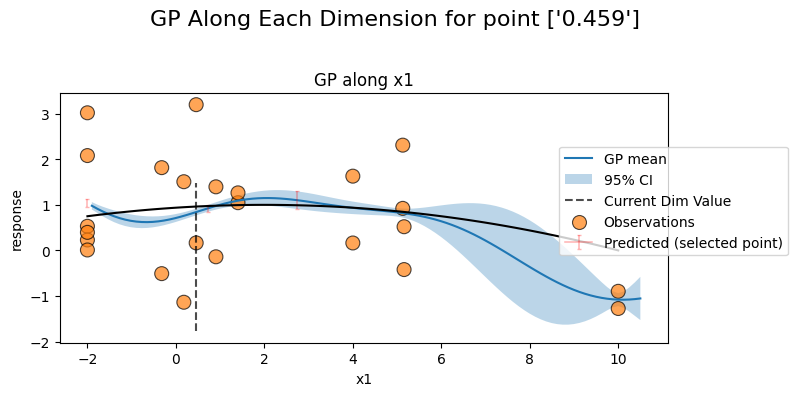

In [12]:
tester = SequentialRuns(test_function, range_parameters, dim_names, metric_name)

runs = tester.run(
    SingleTaskGP,
    n_runs=4,
    technical_repeats=2,
    batch_size=3,
    noise_fn=noise_fn,
    plot_each=False,
)
runs.plot_GP(SingleTaskGP, figsize=(8, 4))
plot_test()

* This simple Kernel is incapable of encompassing noise. Consequently, it overfits.
* Technical repeats slightly improve the situation, however they do not fix the problem.

### GP + noise

Simply adding a lot of noise, significantly improves the fit.
 

[INFO 09-23 20:28:07] ax.api.client: Generated new trial 0 with parameters {'x1': 4.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-23 20:28:07] ax.api.client: Generated new trial 1 with parameters {'x1': 8.559296} using GenerationNode Sobol.


[INFO 09-23 20:28:07] ax.api.client: Generated new trial 2 with parameters {'x1': -1.28094} using GenerationNode Sobol.
[INFO 09-23 20:28:07] ax.api.client: Trial 0 marked COMPLETED.
[INFO 09-23 20:28:07] ax.api.client: Trial 1 marked COMPLETED.
[INFO 09-23 20:28:07] ax.api.client: Trial 2 marked COMPLETED.
[INFO 09-23 20:28:07] ax.api.client: Generated new trial 3 with parameters {'x1': 2.838889} using GenerationNode Sobol.
[INFO 09-23 20:28:07] ax.api.client: Generated new trial 4 with parameters {'x1': 4.430316} using GenerationNode Sobol.
[INFO 09-23 20:28:07] ax.api.client: Generated new trial 5 with parameters {'x1': 5.566537} using GenerationNode Sobol.
[INFO 09-23 20:28:07] ax.api.client: Trial 3 marked COMPLETED.
[INFO 09-23 20:28:07] ax.api.client: Trial 4 marked COMPLETED.
[INFO 09-23 20:28:07] ax.api.client: Trial 5 marked COMPLETED.
[INFO 09-23 20:28:08] ax.api.client: Generated new trial 6 with parameters {'x1': -2.0} using GenerationNode GammaNoiseSGP+qLogExpectedImprove

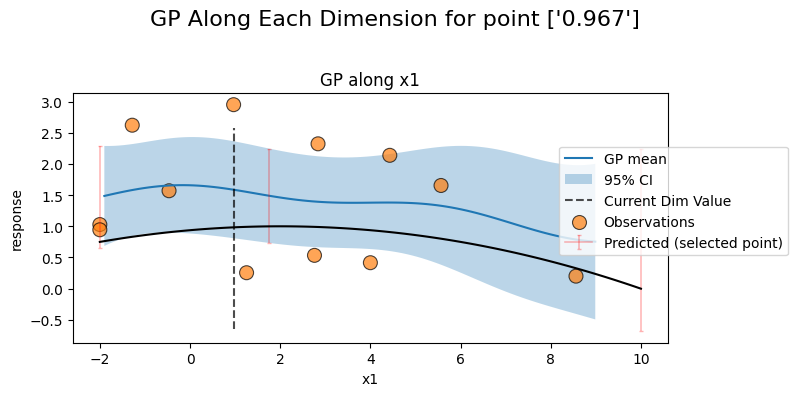

In [13]:
class GammaNoiseSGP(SingleTaskGP):
    """Just add a lot of assumed noise"""

    def __init__(
        self,
        train_X,
        train_Y,
        noise_concentration: float = 10,
        noise_rate: float = 10,
    ):

        likelihood = GaussianLikelihood(
            noise_prior=GammaPrior(noise_concentration, noise_rate)
        )

        super().__init__(
            train_X=train_X,
            train_Y=train_Y,
            likelihood=likelihood,
        )


runs = tester.run(
    GammaNoiseSGP,
    n_runs=4,
    technical_repeats=1,
    batch_size=3,
    noise_fn=noise_fn,
    plot_each=False,
).plot_GP(GammaNoiseSGP, figsize=(8, 4))


plot_test()

* Introducing a noise channel significantly improves fit performance, even if no technical repeats are provided to narrow down the mean.
However,a heteroscedastic, or at least technical repeat aware noise kernel would be preferable.

[INFO 09-23 20:28:11] ax.api.client: Generated new trial 0 with parameters {'x1': 4.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-23 20:28:11] ax.api.client: Generated new trial 1 with parameters {'x1': 6.833889} using GenerationNode Sobol.
[INFO 09-23 20:28:11] ax.api.client: Generated new trial 2 with parameters {'x1': 2.933418} using GenerationNode Sobol.
[INFO 09-23 20:28:11] ax.api.client: Trial 0 marked COMPLETED.
[INFO 09-23 20:28:11] ax.api.client: Trial 3 marked COMPLETED.
[INFO 09-23 20:28:11] ax.api.client: Trial 1 marked COMPLETED.
[INFO 09-23 20:28:11] ax.api.client: Trial 4 marked COMPLETED.
[INFO 09-23 20:28:11] ax.api.client: Trial 2 marked COMPLETED.
[INFO 09-23 20:28:11] ax.api.client: Trial 5 marked COMPLETED.
[INFO 09-23 20:28:12] ax.api.client: Generated new trial 6 with parameters {'x1': 4.730263} using GenerationNode GammaNoiseSGP+qLogExpectedImprovement.
[INFO 09-23 20:28:12] ax.api.client: Generated new trial 7 with parameters {'x1': 8.504992} using Gen

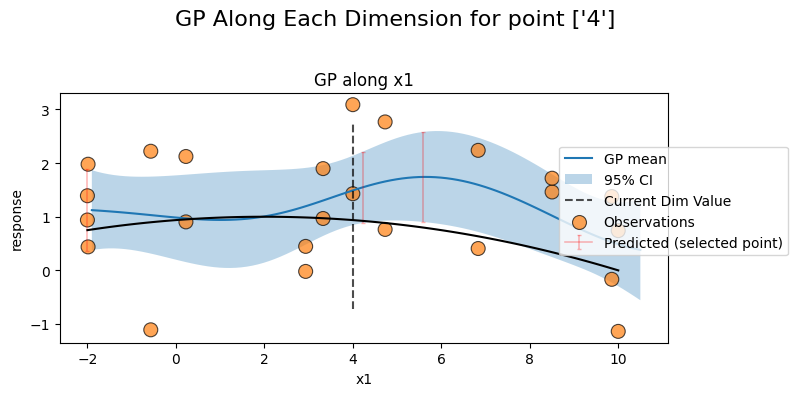

In [14]:
runs = tester.run(GammaNoiseSGP, n_runs=4, technical_repeats=2, batch_size=3, noise_fn=noise_fn, plot_each=False).plot_GP(GammaNoiseSGP, figsize=(8, 4))
plot_test()

It appears that technical repeats significantly improve noise resolution for the kernel, however, more quantitative tests are required.

# Quantification of Noise, technical repeats, and batch size.

6 dimensional hartman function is used for evaluation, due to its high dimensionality, multiple local optima, ridges and non-linear interactions.

In [28]:
# Hartmann 6D benchmark (domain: [0,1]^6). Standard form is for minimization.
# We return the negative so it can be used as a maximization objective (larger is better).
_h6_alpha = torch.tensor([1.0, 1.2, 3.0, 3.2])
_h6_A = torch.tensor([
    [10,  3, 17,  3,  1, 11],
    [ 0.05, 10, 17,  0.1, 8, 14],
    [ 3,  3.5, 1.7, 10, 17, 8],
    [17,  8,  0.05, 10, 0.1, 14],
])
_h6_P = 1e-4 * torch.tensor([
    [1312, 1696, 5569, 124, 8283, 5886],
    [2329, 4135, 8307, 3736, 1004, 9991],
    [2348, 1451, 3522, 2883, 3047, 6650],
    [4047, 8828, 8732, 5743, 1091, 381],
])

def hartmann6(x1, x2, x3, x4, x5, x6):
    """
    Hartmann-6 function (negated for maximization).
    Usage:
        hartmann6(x) where x is length-6 iterable in [0,1]
        or hartmann6(x1, x2, x3, x4, x5, x6)
    """
    args = (x1, x2, x3, x4, x5, x6)
    if len(args) == 1 and hasattr(args[0], "__len__"):
        x = torch.as_tensor(args[0], dtype=torch.float32)
    else:
        x = torch.as_tensor(args, dtype=torch.float32)
    if x.shape != (6,):
        raise ValueError("hartmann6 expects 6-dimensional input.")
    inner = torch.sum(_h6_A * (x - _h6_P) ** 2, dim=1)
    value = -torch.sum(_h6_alpha * torch.exp(-inner))  # standard (to be minimized)
    return -value  # negate so higher is better

# Quick check at known optimum (~minimum of original, hence maximum after negation)
_h6_x_opt = torch.tensor([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])
h_6_max = float(hartmann6(*_h6_x_opt))
h_6_max

3.416637659072876

In [29]:
hartmann6_range_parameters = [
    RangeParameterConfig(name=f"x{i+1}", parameter_type="float", bounds=(0.0, 1.0))
    for i in range(6)
]
dim_names_h6 = [rp.name for rp in hartmann6_range_parameters]

tester = SequentialRuns(hartmann6, hartmann6_range_parameters, dim_names_h6, metric_name)
tester


## Sequential runs no noise

In [53]:
def noise_fn(x):
    return x
runs = tester.run(SingleTaskGP, n_runs=50, technical_repeats=1, batch_size=1, noise_fn=noise_fn, plot_each=False)


[INFO 09-23 20:56:38] ax.api.client: Generated new trial 0 with parameters {'x1': 0.5, 'x2': 0.5, 'x3': 0.5, 'x4': 0.5, 'x5': 0.5, 'x6': 0.5} using GenerationNode CenterOfSearchSpace.
[INFO 09-23 20:56:38] ax.api.client: Trial 0 marked COMPLETED.
[INFO 09-23 20:56:38] ax.api.client: Generated new trial 1 with parameters {'x1': 0.145172, 'x2': 0.525847, 'x3': 0.776986, 'x4': 0.07506, 'x5': 0.292686, 'x6': 0.50179} using GenerationNode Sobol.
[INFO 09-23 20:56:38] ax.api.client: Trial 1 marked COMPLETED.
[INFO 09-23 20:56:38] ax.api.client: Generated new trial 2 with parameters {'x1': 0.655149, 'x2': 0.443757, 'x3': 0.492523, 'x4': 0.630645, 'x5': 0.673312, 'x6': 0.288602} using GenerationNode Sobol.
[INFO 09-23 20:56:38] ax.api.client: Trial 2 marked COMPLETED.
[INFO 09-23 20:56:38] ax.api.client: Generated new trial 3 with parameters {'x1': 0.867466, 'x2': 0.88127, 'x3': 0.528851, 'x4': 0.377139, 'x5': 0.95916, 'x6': 0.126411} using GenerationNode Sobol.
[INFO 09-23 20:56:38] ax.api.cl

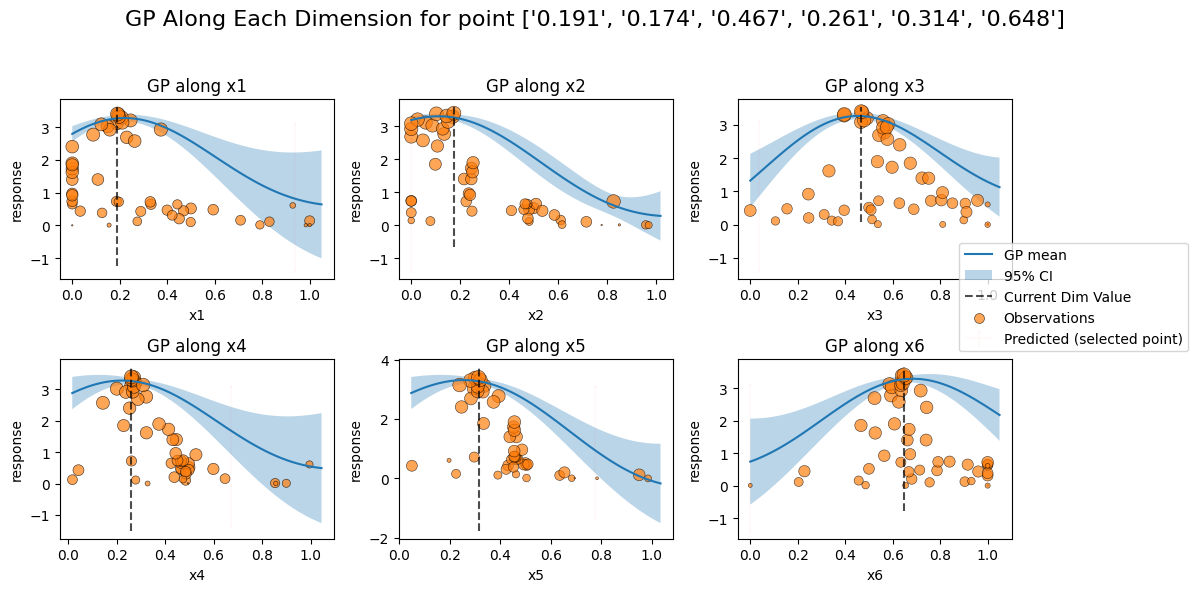

In [51]:
runs.plot_GP(SingleTaskGP)

In [60]:
def get_y_data(runs, dim_names, test_func):

    df = runs.get_batch_observations().sort_values(by='trial_index', ascending=True)
    df = df.groupby(["trial_index", *dim_names])['response'].mean().reset_index()

    df['y_true'] = df[dim_names_h6].apply(lambda r: float(test_func(*r.values)), axis=1)
    df['error'] = df['response'] - df['y_true']


    percentile = 0.95
    df = df[(df['response']>percentile*h_6_max) & (df['y_true']>percentile*h_6_max)]
    return df
df = get_y_data(runs, dim_names_h6, hartmann6)
df

,trial_index,x1,x2,x3,x4,x5,x6,response,y_true,error
24,24,0.205390,0.168808,0.455926,0.285487,0.295844,0.639924,3.386313,3.386313,0.0
25,25,0.160088,0.206659,0.440885,0.292112,0.346242,0.664145,3.259273,3.259273,0.0
27,27,0.228918,0.126936,0.441597,0.292560,0.348326,0.657071,3.294382,3.294382,0.0
30,30,0.241724,0.181613,0.461689,0.291973,0.318535,0.659194,3.362013,3.362013,0.0
31,31,0.221395,0.172246,0.452953,0.265657,0.325913,0.642295,3.373295,3.373295,0.0
32,32,0.240182,0.182226,0.447934,0.282084,0.324556,0.626572,3.335168,3.335168,0.0
33,33,0.210683,0.160617,0.459384,0.265818,0.312606,0.658294,3.402296,3.402296,0.0
34,34,0.200384,0.154050,0.454543,0.257336,0.310835,0.659417,3.395006,3.395006,0.0
